In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from scipy.fftpack import dct, idct
from scipy.optimize import minimize
sys.path.append(os.path.join('..','addDependencies','UTILS'))
from cosamp_fn import cosamp
# cosamp function is available at https://github.com/avirmaux/CoSaMP

plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams.update({'font.size': 18})

In [3]:
import librosa

## Loading the audio signal

In [4]:
file_path = '../data/rawSampleAudios/Voice 002.m4a'
audio_data, sample_rate = librosa.load(file_path)

print(f"Audio data: {audio_data}")
print(f"Sample rate: {sample_rate}")

/tmp/ipykernel_415569/3703608216.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sample_rate = librosa.load(file_path)
/home/jovyan/my-conda-envs/V2Phys215Project/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Audio data: [ 9.3132257e-10 -2.5611371e-09  1.8626451e-09 ... -1.0505662e-01
 -8.7623805e-02 -8.3545819e-02]
Sample rate: 22050


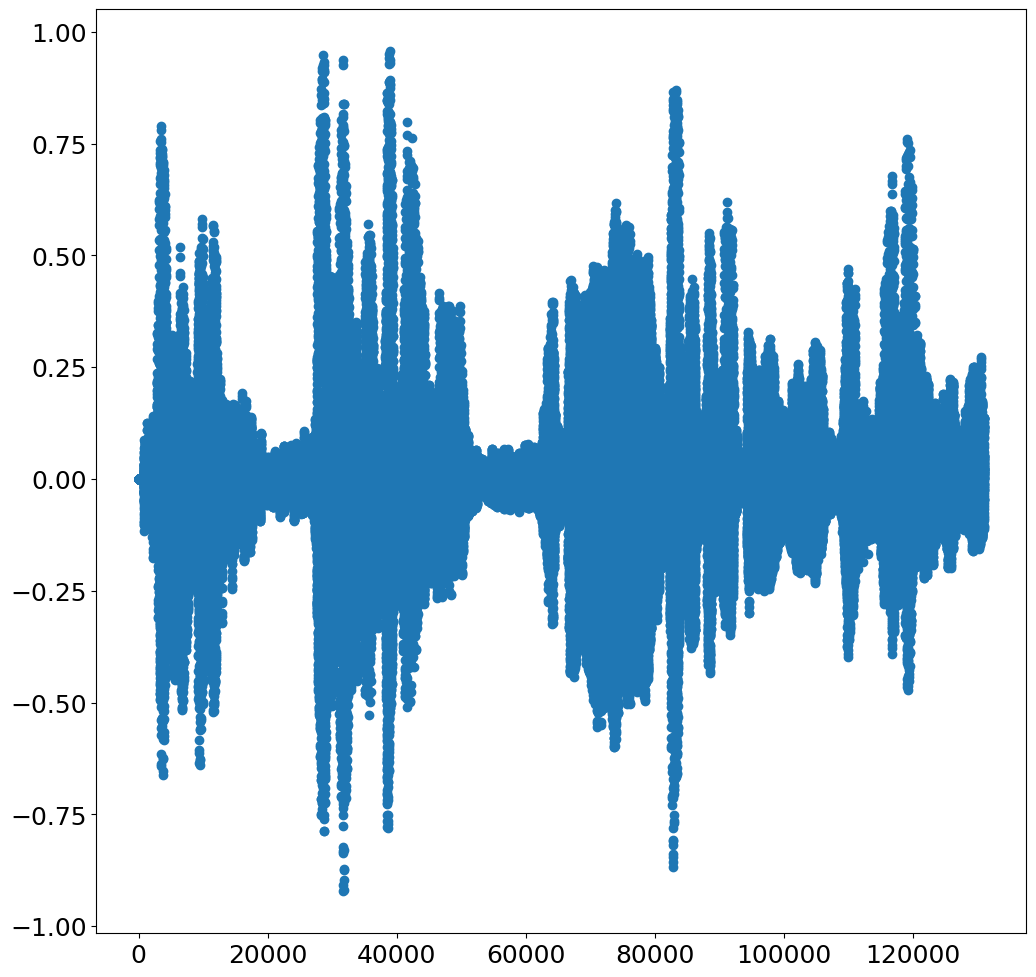

In [5]:
plt.scatter(np.arange(audio_data.size), audio_data)

## Getting the Fourier Transform

In [6]:
np.abs(np.fft.fftshift(np.fft.fft(audio_data)))

array([0.03999657, 0.03998961, 0.0399897 , ..., 0.03998846, 0.0399897 ,
       0.03998961], dtype=float32)

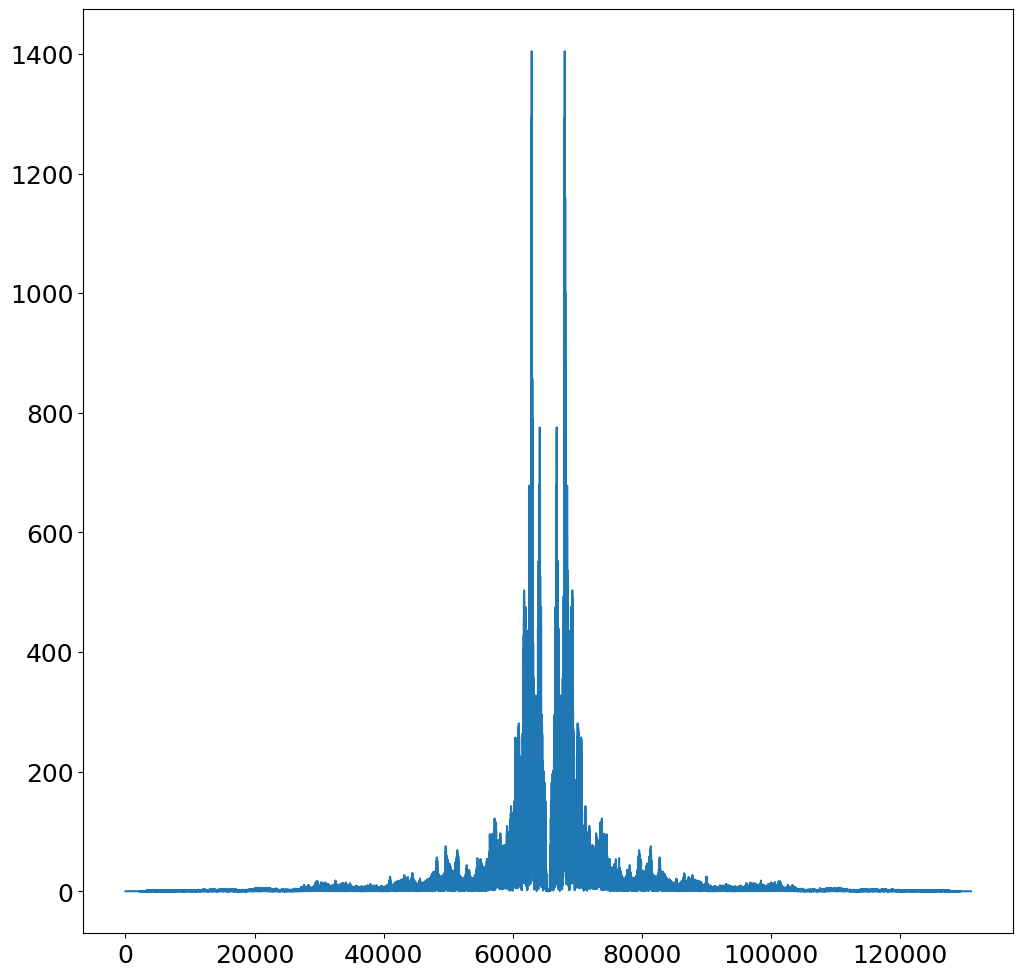

In [7]:
plt.plot(np.abs(np.fft.fftshift(np.fft.fft(audio_data))))

## chirp signal

In [8]:
import numpy as np
from matplotlib.pyplot import tight_layout
from scipy.signal import chirp, square, ShortTimeFFT
from scipy.signal.windows import gaussian
import matplotlib.pyplot as plt

N, T = 4096, 0.01  # number of samples and sampling interval for 10 s signal
t = np.arange(N) * T  # timestamps

x_lin = chirp(t, f0=1, f1=2, t1=N*T, method='linear')

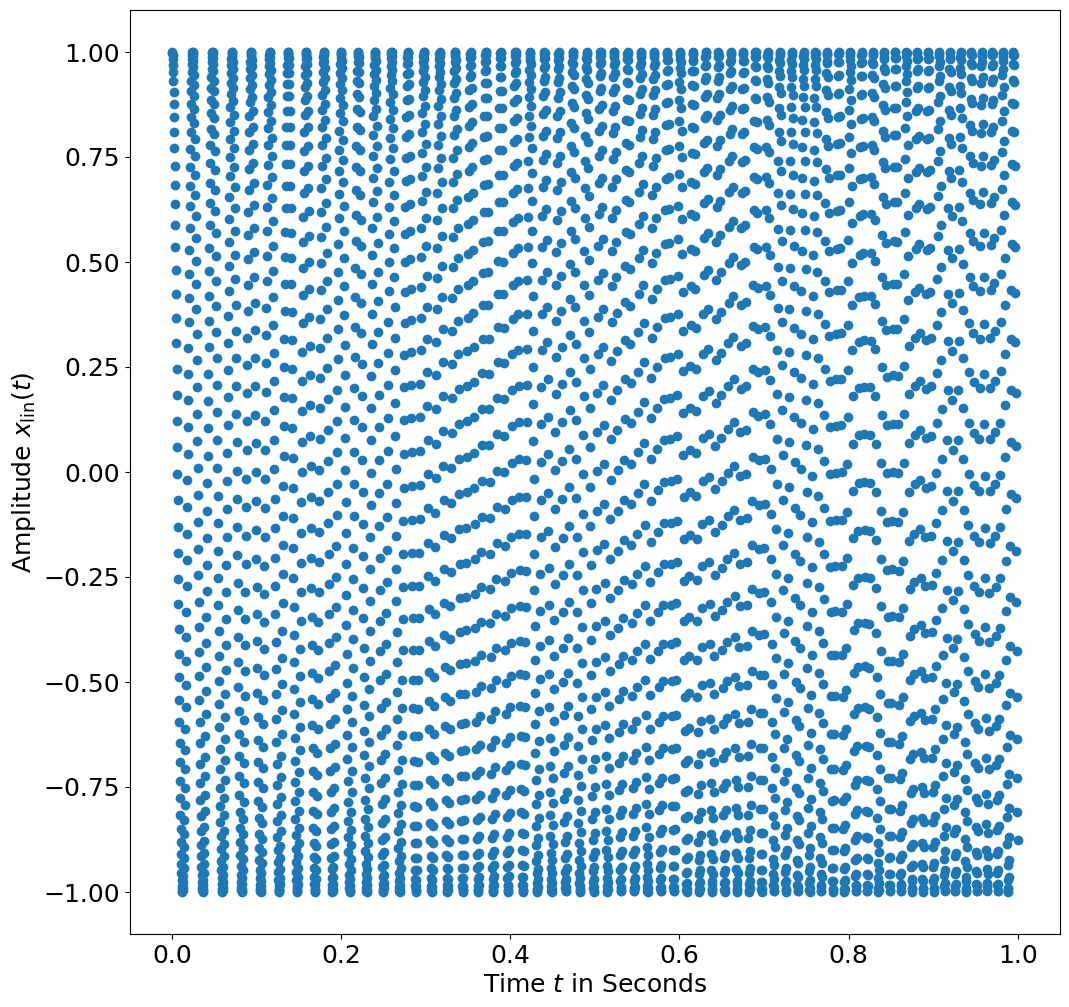

In [24]:
fg0, ax0 = plt.subplots()
ax0.set(xlabel="Time $t$ in Seconds", ylabel=r"Amplitude $x_\text{lin}(t)$")
ax0.scatter(t, x_lin)
plt.show()

## Reconstruction of the audio signal

In [25]:
## Generate signal, DCT of signal

n = 4096 # points in high resolution signal
t = np.linspace(0,1,n)
#x = np.cos(2 * 97 * np.pi * t) + 0.15*np.cos(2 * 777 * np.pi * t) + np.cos(2 * 500 * np.pi * t)
x = x_lin
#x = audio_data[start:start+n]

xt = np.fft.fft(x) # Fourier transformed signal
PSD = xt * np.conj(xt) / n # Power spectral density

In [26]:
## Randomly sample signal
p = 128 # num. random samples, p = n/32
perm = np.floor(np.random.rand(p) * n).astype(int)
y = x[perm]

#y = np.linspace(0, 1, p)

In [27]:
np.identity(n)

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [28]:
## Solve compressed sensing problem
Psi = dct(np.identity(n)) # Build Psi
display(Psi)
Theta = Psi[perm,:]       # Measure rows of Psi

s = cosamp(Theta,y,10,epsilon=1.e-10,max_iter=10) # CS via matching pursuit
xrecon = idct(s) # reconstruct full signal

array([[ 2.00000000e+00,  1.99999985e+00,  1.99999941e+00, ...,
         2.30097067e-03,  1.53398064e-03,  7.66990375e-04],
       [ 2.00000000e+00,  1.99999868e+00,  1.99999471e+00, ...,
        -6.90289984e-03, -4.60193830e-03, -2.30097067e-03],
       [ 2.00000000e+00,  1.99999632e+00,  1.99998529e+00, ...,
         1.15047925e-02,  7.66988514e-03,  3.83494962e-03],
       ...,
       [ 2.00000000e+00, -1.99999632e+00,  1.99998529e+00, ...,
        -1.15047925e-02,  7.66988514e-03, -3.83494962e-03],
       [ 2.00000000e+00, -1.99999868e+00,  1.99999471e+00, ...,
         6.90289984e-03, -4.60193830e-03,  2.30097067e-03],
       [ 2.00000000e+00, -1.99999985e+00,  1.99999941e+00, ...,
        -2.30097067e-03,  1.53398064e-03, -7.66990375e-04]])

Iteration 8

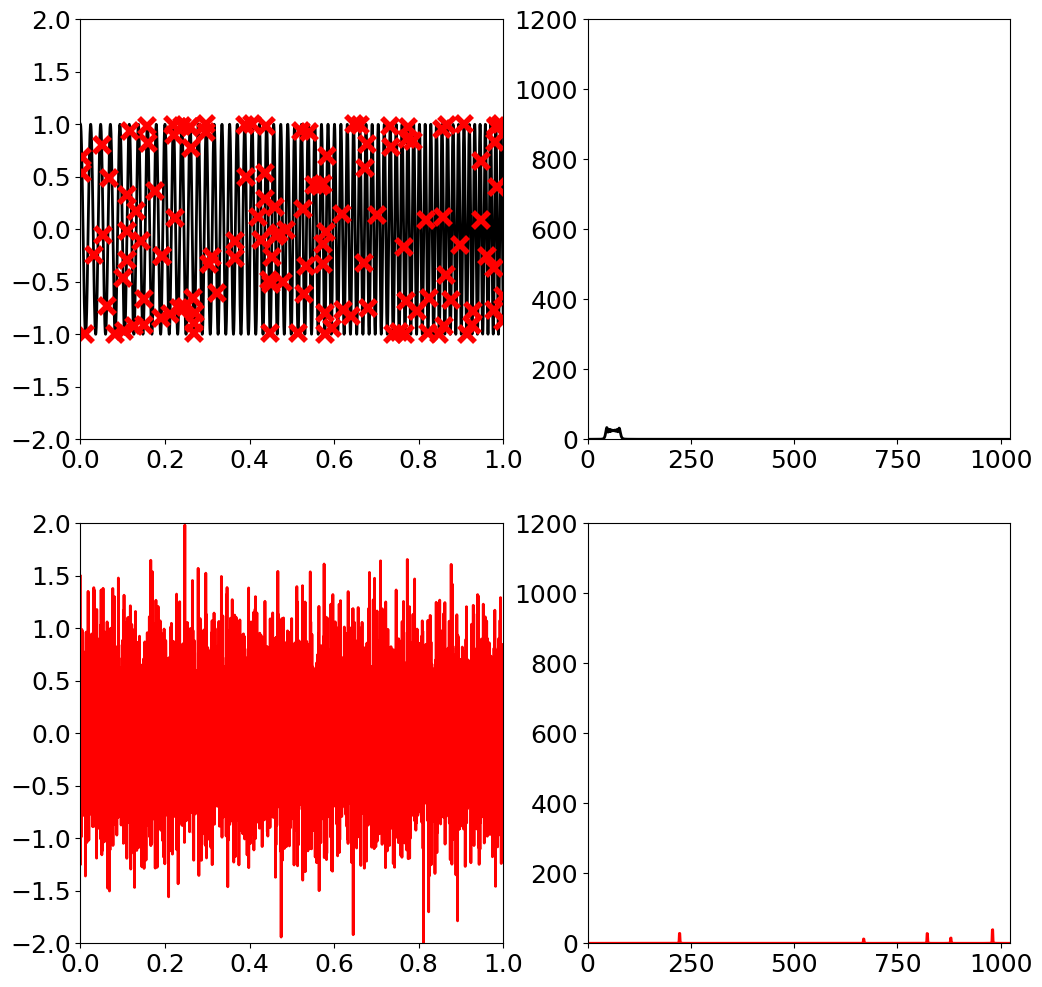

In [29]:
## Plot
time_window = np.array([0,4096])/n
freq = np.arange(n)
L = int(np.floor(n/2))


fig,axs = plt.subplots(2,2)
axs = axs.reshape(-1)

axs[1].plot(freq[:L],PSD[:L],color='k',linewidth=2)
axs[1].set_xlim(0, 1024)
axs[1].set_ylim(0, 1200)

axs[0].plot(t,x,color='k',linewidth=2)
axs[0].plot(perm/n,y,color='r',marker='x',linewidth=0,ms=12,mew=4)
axs[0].set_xlim(time_window[0],time_window[1])
axs[0].set_ylim(-2, 2)

axs[2].plot(t,xrecon,color='r',linewidth=2)
axs[2].set_xlim(time_window[0],time_window[1])
axs[2].set_ylim(-2, 2)

xtrecon = np.fft.fft(xrecon,n) # computes the (fast) discrete fourier transform
PSDrecon = xtrecon * np.conj(xtrecon)/n # Power spectrum (how much power in each freq)

axs[3].plot(freq[:L],PSDrecon[:L],color='r',linewidth=2)
axs[3].set_xlim(0, 1024)
axs[3].set_ylim(0, 1200)

plt.show()

In [ ]:
## L1-Minimization using SciPy
def L1_norm(x):
    return np.linalg.norm(x,ord=1)

constr = ({'type': 'eq', 'fun': lambda x:  Theta @ x - y})
x0 = np.linalg.pinv(Theta) @ y 
res = minimize(L1_norm, x0, method='SLSQP',constraints=constr)
s = res.x

In [ ]:
Theta.shape

In [ ]:
y.shape

In [ ]:
##Getting Accuracy 
meanL2error = np.sqrt(sum((x-xrecon)**2)/Theta.shape[1])
meanL1error = sum(abs(x-xrecon))/Theta.shape[1]

In [ ]:
meanL1error